# Chessboard Analysis Notebook

This program processes an image of a chessboard to analyze its structure, detect individual squares, and classify them as black or white. By leveraging image processing techniques such as contour detection, perspective transformation, and intensity analysis, the program ensures accurate identification of the chessboard grid. Additionally, it calculates the accuracy of the detected black and white squares against expected values, providing insights into the reliability of the detection process.

This code aims to process an image of a chessboard to identify and count the number of black and white squares while calculating the accuracy of detection. The process involves several key steps:

   - **Image Preprocessing:** The input image is converted to grayscale, and histogram equalization is applied to enhance contrast.
   - **Thresholding and Contour Detection:** The image is binarized using thresholding, and contours are detected to isolate the chessboard.
   - **Perspective Transformation:** The largest contour is used to approximate the chessboard's corners and perform a perspective transform to obtain a cropped, top-down view.
   - **Square Analysis:** The cropped chessboard is divided into an 8x8 grid, and each square's intensity is analyzed to classify it as black or white.
   - **Accuracy Calculation:** The detected black and white squares are compared to expected values, and the accuracy of the detection is computed.
   
This workflow ensures robust detection and verification of chessboard squares, even in challenging lighting conditions.

In [3]:
!pip install -r requirements.txt

In [4]:

import cv2
import numpy as np
import matplotlib.pyplot as plt


**`expected_black`** and **`expected_white`**: Represent the standard count of black and white squares (32 each) on a chessboard.

#### **Function: `show_image`** 
A utility to display images in Jupyter Notebooks for debugging and visualization.

In [5]:
# Initialize the expected count of black and white squares on a chessboard
expected_black = 32
expected_white = 32

# Function to display an image with a title in a Jupyter Notebook
# - 'title': Title of the image to be displayed.
# - 'image': The image array to display.
# - 'cmap': Optional; a colormap for grayscale images.
# The function uses matplotlib to render the image and removes axes for better visualization.
def show_image(title, image, cmap=None):
    plt.figure(figsize=(8, 6))  # Set the figure size
    plt.title(title)  # Set the title
    if cmap:  
        plt.imshow(image, cmap=cmap)  # Display grayscale image
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.axis("off")  # Hide axes for a cleaner display
    plt.show()


# Define paths to the input images

#### **Purpose** 
* Load two images from specified file paths for further analysis.

#### **Key Steps** 
1. **Image Paths**: Define the file paths for the images (`image_path1` and `image_path2`). 
2. **Load Images**: Use `cv2.imread` to read the images into memory.
3.  **Validation**: Check if the images are loaded correctly: 
    * Print an error message if any image fails to load. 
    * Confirm successful loading if both images are accessible.

In [6]:
# Define paths to the input images
image_path1 = "data/image4.jpg"  # Path to the first image
image_path2 = "data/image6.jpg"  # Path to the second image

# Load the images using OpenCV
image1 = cv2.imread(image_path1)  # Load the first image
image2 = cv2.imread(image_path2)  # Load the second image

# Verify if the images have been loaded successfully
if image1 is None or image2 is None:
    print("Error: One or more images could not be loaded.")  # Error message if loading fails
else:
    print("Images loaded successfully!")  # Success message if both images are loaded

Images loaded successfully!


### To visually inspect the original images and ensure they are loaded correctly.

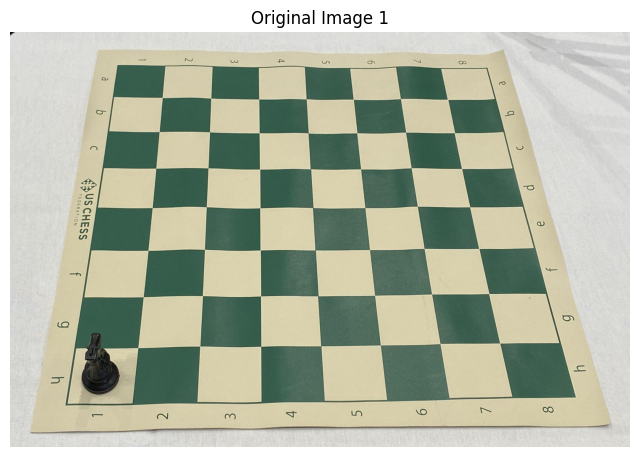

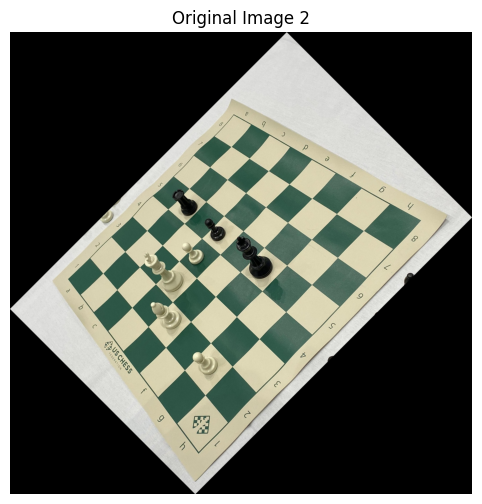

In [7]:
# Debug: Display the original images
show_image("Original Image 1", image1)

show_image("Original Image 2", image2)

# Convert the original images to grayscale
To convert the images to grayscale, simplifying further image processing by reducing the color channels.
Grayscale images are often used in computer vision tasks as they contain only intensity values, making processing faster and less complex.

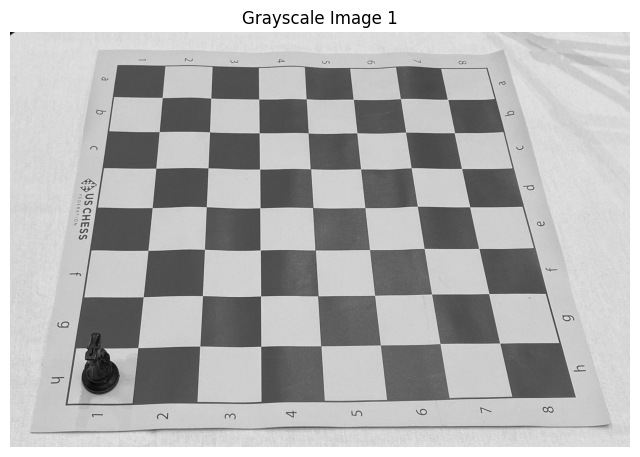

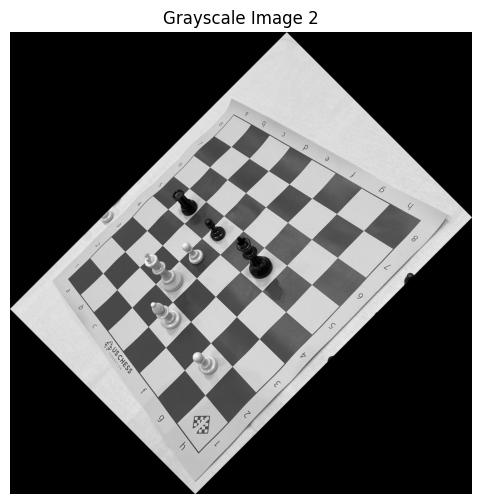

In [8]:
# Convert the original images to grayscale
# Grayscale conversion simplifies image processing by reducing color channels to a single intensity channel
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)  # Convert the first image to grayscale
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)  # Convert the second image to grayscale

# Debug Step: Visualize the grayscale images
# Helps confirm successful conversion to grayscale
show_image("Grayscale Image 1", gray1)  # Display the first grayscale image
show_image("Grayscale Image 2", gray2)  # Display the second grayscale image


# Apply CLAHE
Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance the contrast of the grayscale images. CLAHE improves the local contrast by equalizing histograms in small regions (tiles) of the image, which is particularly useful in images with varying lighting conditions.

## But in our case
When increasing the `clipLimit` in CLAHE (Contrast Limited Adaptive Histogram Equalization), the contrast enhancement becomes more aggressive. While this can improve local contrast in certain areas, it can also introduce excessive noise or exaggerate irregularities in the image. This effect can distort the appearance of objects, like a chessboard, making it difficult for image processing algorithms to identify the board correctly, especially when the image is rotated.

### Why It Happens:
High `clipLimit` Values: When the `clipLimit` is too high, small details in the image become exaggerated, which may lead to abnormal contrast in different regions. In rotated or transformed images, the board might become harder to detect due to these unwanted contrast changes, particularly in areas that should remain uniform (e.g., the squares of a chessboard).
Board Detection: The algorithm relies on clear edges and uniform regions (the chessboard squares). Excessive contrast or noise can make these features harder to detect, especially when the image is rotated.

### Solution:
To avoid abnormal contrast that disturbs chessboard detection:

Use a moderate `clipLimit` value, typically between 1.0 and 2.0, based on the image's lighting and quality.


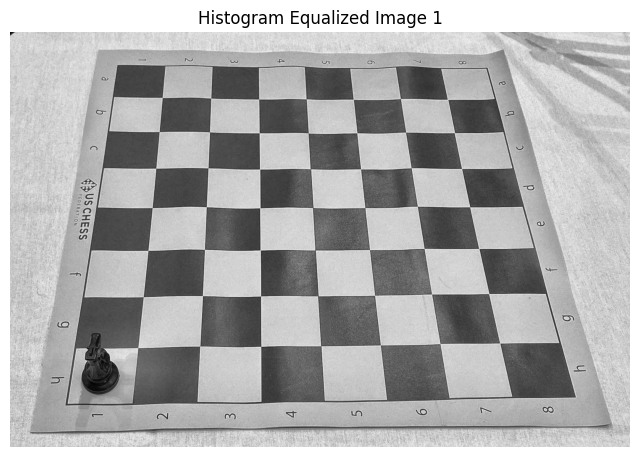

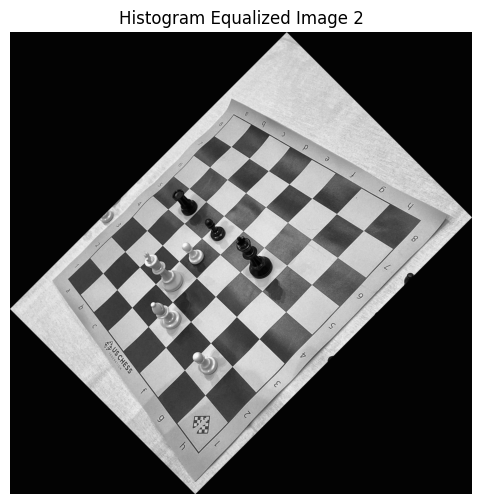

In [9]:
# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve the contrast of the grayscale images
# CLAHE enhances local contrast by applying histogram equalization to small tiles, reducing over-amplification of noise
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Create CLAHE object with specified parameters

# Apply CLAHE to the grayscale images
gray_equalized1 = clahe.apply(gray1)  # Apply CLAHE to the first grayscale image
gray_equalized2 = clahe.apply(gray2)  # Apply CLAHE to the second grayscale image

# Debug Step: Visualize the contrast-enhanced images
# This helps to see the improvement in contrast after CLAHE is applied
show_image("Histogram Equalized Image 1", gray_equalized1)  # Display the first CLAHE-enhanced image
show_image("Histogram Equalized Image 2", gray_equalized2)  # Display the second CLAHE-enhanced image


# Apply binary inverse thresholding 
To apply binary inverse thresholding, which converts the grayscale image into a binary image with inverted values. This step helps isolate the chessboard grid by blacking out the background and making the grid easily detectable for contour analysis.

### Reason for Inverse Thresholding
- In the input images, the chessboard grid has a surrounding edge border that helps identify the entire grid area.
- By inverting the binary threshold:
    - White (1) represents the surrounding edge border, as it has higher intensity values, making it easier to detect contours.
    - Black (0) represents the background, effectively eliminating it from contour detection.
- This ensures only the grid and its borders are considered for further processing, reducing noise and improving accuracy in finding the 8x8 grid.

### Debug:
Display the thresholded images to confirm that the background is blacked out, leaving the chessboard surrounding edge border.

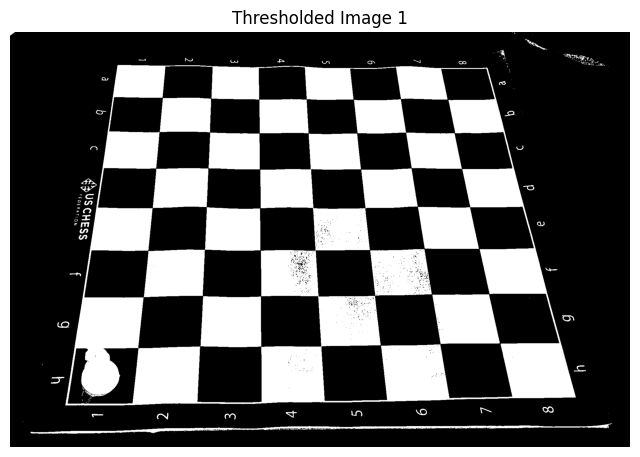

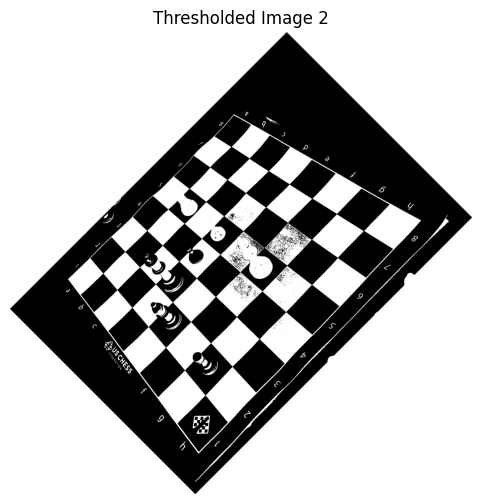

In [10]:
# Apply binary inverse thresholding to the equalized grayscale images
# The threshold value of 127 is used to separate the foreground (white) from the background (black)
# The cv2.THRESH_BINARY_INV flag inverts the thresholding result, where values greater than 127 become black (0), and values less than 127 become white (255)
_, thresholded1 = cv2.threshold(gray_equalized1, 127, 255, cv2.THRESH_BINARY_INV)  # Apply thresholding to the first image
_, thresholded2 = cv2.threshold(gray_equalized2, 127, 255, cv2.THRESH_BINARY_INV)  # Apply thresholding to the second image

# Debug Step: Display the thresholded (binary inverse) images
# This helps visualize the segmentation result after thresholding
show_image("Thresholded Image 1", thresholded1)  # Display the thresholded version of the first image
show_image("Thresholded Image 2", thresholded2)  # Display the thresholded version of the second image


# Find contours
## What is a Contour?
A contour is a curve or boundary that joins all continuous points with the same color or intensity in an image. In computer vision, contours are used to represent the shape and boundary of objects within an image. Contours are essentially edges but grouped into connected components for object representation.

## Why Do We Use Contours?
Contours help:

- Detect Object Boundaries: Identify the outer shape or edges of objects in an image.
- Feature Extraction: Analyze the structure and geometry of objects (e.g., area, perimeter, orientation).
- Segmentation: Separate an object from its background.
- Shape Analysis: Classify or compare objects based on their shapes.

## Use of Contours in our Code

1. Locate the Chessboard:

    - The largest contour likely corresponds to the chessboard, as the thresholded image emphasizes its boundary.
    - Sorting contours by area helps prioritize the grid's boundary over smaller, irrelevant objects.

2. Filter Noise:

    - Using binary inverse thresholding, the background is blacked out, leaving the chessboard in white. This ensures the contour-detection algorithm focuses on the chessboard instead of noise or unwanted details.

3. Grid Detection:

    - The chessboard grid is enclosed within the detected contour. Once the contour of the grid is isolated, further processing can refine the grid lines and detect the 8x8 squares.

4. Visual Confirmation:

    - Drawing contours over the image helps debug and confirm that the desired object (the chessboard) is detected correctly.

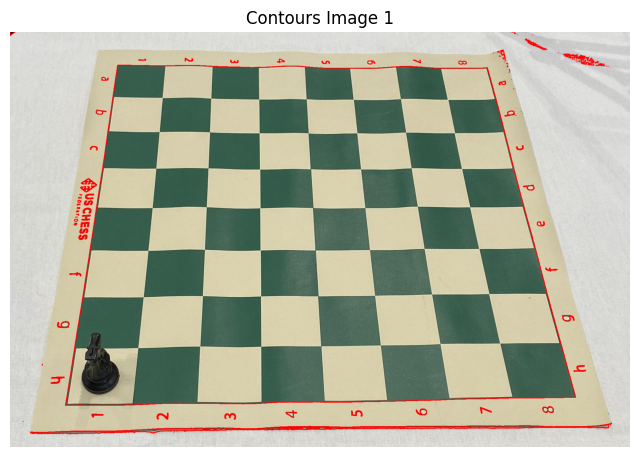

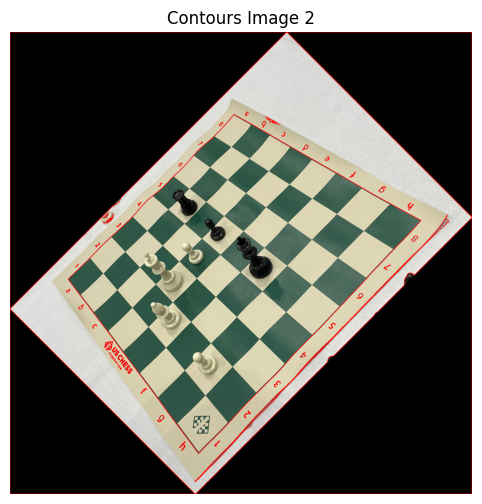

In [11]:
# Find contours in the thresholded images
# cv2.RETR_EXTERNAL: Retrieves only the external contours (outermost boundaries).
# cv2.CHAIN_APPROX_SIMPLE: Compresses horizontal, vertical, and diagonal segments, keeping only essential points to represent the contour.
contours1, _ = cv2.findContours(thresholded1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours in the first image
contours2, _ = cv2.findContours(thresholded2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours in the second image

# Sort contours by area in descending order
# This ensures the largest contour (likely the chessboard) is considered first
contours1 = sorted(contours1, key=cv2.contourArea, reverse=True)  # Sort contours for the first image
if contours1:  # Check if any contours are found
    # Debug Step: Display contours on the first image
    contour_debug1 = image1.copy()  # Create a copy of the original image for visualization
    cv2.drawContours(contour_debug1, contours1, -1, (0, 0, 255), 2)  # Draw all contours in red with thickness 2
    show_image("Contours Image 1", contour_debug1)  # Display the contours overlaid on the first image
else:
    print("Error: No contours found for first image.")  # Display an error message if no contours are detected

contours2 = sorted(contours2, key=cv2.contourArea, reverse=True)  # Sort contours for the second image
if contours2:  # Check if any contours are found
    # Debug Step: Display contours on the second image
    contour_debug2 = image2.copy()  # Create a copy of the original image for visualization
    cv2.drawContours(contour_debug2, contours2, -1, (0, 0, 255), 2)  # Draw all contours in red with thickness 2
    show_image("Contours Image 2", contour_debug2)  # Display the contours overlaid on the second image
else:
    print("Error: No contours found for second image.")  # Display an error message if no contours are detected


# Approximate the polygonal curve
This step simplifies the largest contour (chessboard boundary) into a polygon with fewer points, retaining its shape while reducing unnecessary details.

### Why This is Needed?
- Simplifies the detected contour for easier processing.
- Focuses on key geometric features, like the corners of the chessboard.
- Reduces noise and helps in tasks such as aligning or identifying the grid structure.

In [12]:
# Approximate the polygonal curve of the largest contour
# cv2.arcLength() calculates the perimeter of the contour
# epsilon defines the maximum distance between the original contour and its approximation; 2% of the perimeter is used here
epsilon1 = 0.02 * cv2.arcLength(contours1[0], True)  # Calculate epsilon for the largest contour in the first image
approx1 = cv2.approxPolyDP(contours1[0], epsilon1, True)  # Approximate the polygonal curve for the largest contour in the first image

epsilon2 = 0.02 * cv2.arcLength(contours2[0], True)  # Calculate epsilon for the largest contour in the second image
approx2 = cv2.approxPolyDP(contours2[0], epsilon2, True)  # Approximate the polygonal curve for the largest contour in the second image


# Visualize the approximated corners

### Why Do This?
- This step visually confirms that the corners of the approximated contour (chessboard boundary) are correctly identified and labeled.
- It helps ensure the approximation and subsequent grid alignment are accurate.


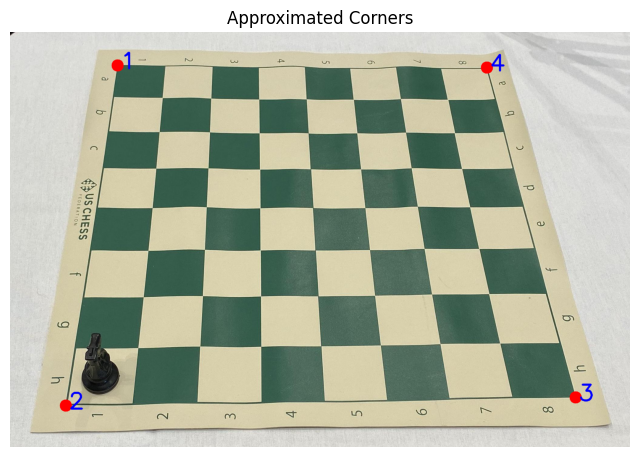

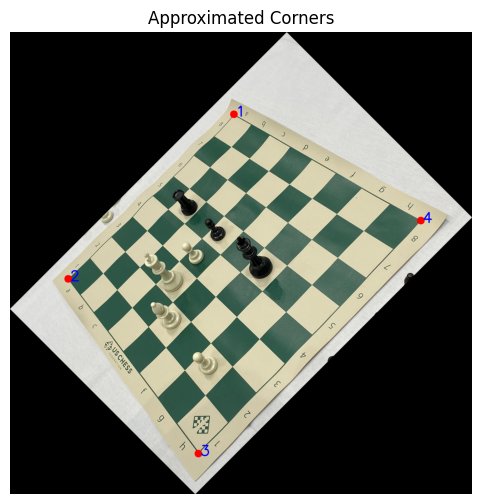

In [13]:
# Visualize the approximated corners on the images
# Combine the images and their corresponding approximations into lists for processing
images = [image1, image2]  # List of original images
approxs = [approx1, approx2]  # List of approximated polygonal curves (corners)

# Iterate over each image and its approximated corners
for idx, image in enumerate(images, start=1):  
    debug_image = image.copy()  # Create a copy of the original image for visualization
    for i, point in enumerate(approxs[idx-1]):  # Iterate through each point in the approximated polygon
        x, y = point.ravel()  # Flatten the coordinates of the corner point
        cv2.circle(debug_image, (x, y), 20, (0, 0, 255), -1)  # Draw a red circle at each corner
        cv2.putText(debug_image, f"{i + 1}", (x + 10, y + 10), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (255, 0, 0), 5)  
        # Label each corner with its index number in blue text
    show_image("Approximated Corners", debug_image)  # Display the image with corners highlighted and labeled


# Chessboard Processing Function

## Purpose
The `process_chessboard` function evaluates the number of black and white squares on a chessboard image and calculates their detection accuracy compared to expected values.



1. **Perspective Transformation**
The chessboard is transformed into a top-down view using the detected corners. This ensures proper alignment, simplifying square-based analysis.

2. **Square Division**
The transformed image is divided into an 8x8 grid to correspond to the chessboard squares. Each square is processed individually to determine if it is black or white.

3. **Square Classification**
Each square is analyzed based on its intensity:
   - The **mean intensity** of each square (`np.mean(square)`) is calculated. This represents the average brightness of the square.
   - A **dynamic threshold** (`np.mean(gray_cropped)`) is used to classify the square as black or white. Squares darker than the threshold are classified as black, and lighter squares as white.


### Why Use `np.mean(gray_cropped)`?

The mean intensity of the entire grayscale chessboard image (`gray_cropped`) serves as a **dynamic threshold**. Here's why:

1. **Dynamic Adaptability**: 
   - Different chessboards or lighting conditions can vary in overall brightness. Using the mean intensity of the whole image ensures the threshold adapts to these variations.
   - For example, if the image is dimly lit, the mean intensity will be lower, resulting in a lower threshold. This prevents misclassification of squares.

2. **Avoiding Fixed Thresholds**:
   - A fixed intensity value might not work well across varying images because of differences in lighting, shadows, or camera exposure. 
   - The dynamic approach ensures the method remains robust across a variety of conditions.

3. **Global Context**:
   - By considering the mean intensity of the entire chessboard, the method establishes a baseline to distinguish between darker (black) and lighter (white) squares relative to the overall brightness.


### Challenges with `np.mean(gray_cropped)`
While effective, using the mean intensity of the entire image can encounter issues:
- **Chess Pieces**: The presence of chess pieces can alter the mean intensity of individual squares, leading to potential misclassifications.
- **Complex Patterns**: Boards with significant texture or design might affect the accuracy of this approach.


### Why Use This Approach?

1. **Simplicity**: Calculating mean intensities is computationally efficient and straightforward.
2. **Robustness**: The dynamic threshold adapts to lighting and image conditions, making the method versatile.
3. **Visual Feedback**: The color-coded visualization helps debug and refine the classification process.

### Improvements to Consider
- **Advanced Techniques**: machine learning models could improve square classification, especially in challenging scenarios.


In [ ]:
def process_chessboard(image, approx, expected_black, expected_white, debug=True):
    """
    Processes a chessboard image to evaluate black and white squares.

    Args:
        image: Input chessboard image.
        approx: Approximated corners of the chessboard contour.
        expected_black: Expected count of black squares (typically 32).
        expected_white: Expected count of white squares (typically 32).
        debug: Flag to enable/disable debug visualizations.

    Returns:
        black_accuracy: Accuracy of black square detection.
        white_accuracy: Accuracy of white square detection.
        overall_accuracy: Combined accuracy of both black and white square detection.
    """
    # Ensure at least 4 points are available to define the chessboard corners
    if len(approx) >= 4:
        # Extract the first 4 corners and convert them into a float32 array
        points = np.array([point.ravel() for point in approx[:4]], dtype="float32")

        # Calculate the width and height of the transformed chessboard
        width = int(max(np.linalg.norm(points[0] - points[1]), np.linalg.norm(points[2] - points[3])))
        height = int(max(np.linalg.norm(points[0] - points[3]), np.linalg.norm(points[1] - points[2])))

        # Define the destination rectangle for perspective transformation
        dst_rect = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")

        # Compute the perspective transform matrix
        M = cv2.getPerspectiveTransform(points, dst_rect)

        # Apply the perspective transformation to obtain a top-down view of the chessboard
        cropped_image = cv2.warpPerspective(image, M, (width, height))

        # Debug: Display the cropped chessboard image
        if debug:
            show_image("Cropped Chessboard", cropped_image)

        # Divide the chessboard into 8x8 squares
        square_size = (cropped_image.shape[1] // 8, cropped_image.shape[0] // 8)
        black_count = 0  # Count of detected black squares
        white_count = 0  # Count of detected white squares

        # Convert the cropped image to grayscale for intensity analysis
        gray_cropped = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        color_coded = cropped_image.copy()  # Copy of the image for color-coded visualization

        # Loop through each square in the 8x8 grid
        for row in range(8):
            for col in range(8):
                # Determine the bounding box for the current square
                x_start = col * square_size[0]
                y_start = row * square_size[1]
                x_end = x_start + square_size[0]
                y_end = y_start + square_size[1]

                # Extract the square's region from the grayscale image
                square = gray_cropped[y_start:y_end, x_start:x_end]
                ##show_image("cropped_image", square)
                mean_intensity = np.mean(square)  # Calculate the mean intensity of the square
                dynamic_threshold = np.mean(gray_cropped)  # Calculate a dynamic threshold based on the whole image (on some image getting value near 144)
                # Classify the square as black or white based on its intensity
                if mean_intensity < dynamic_threshold:  # Square is darker than the threshold
                    black_count += 1
                    color = (0, 0, 0)  # Black for visualization
                else:  # Square is lighter than the threshold
                    white_count += 1
                    color = (255, 255, 255)  # White for visualization

                # Fill the square with the detected color on the visualization image
                cv2.rectangle(color_coded, (x_start, y_start), (x_end, y_end), color, -1)

        # Debug: Display the color-coded chessboard visualization
        if debug:
            show_image("Color-coded Chessboard", color_coded)

        # Print the detected counts of black and white squares
        print(f"Black squares: {black_count}")
        print(f"White squares: {white_count}")

        # Adjust counts to fit the expected values if necessary
        if black_count > expected_black:
            white_count = 64 - black_count  # Recalculate white count to maintain the 8x8 total

        # Calculate the number of correctly detected black and white squares
        correct_black = min(black_count, expected_black)
        correct_white = min(white_count, expected_white)

        # Compute detection accuracy percentages
        black_accuracy = (correct_black / expected_black) * 100
        white_accuracy = (correct_white / expected_white) * 100
        overall_accuracy = ((correct_black + correct_white) / (expected_black + expected_white)) * 100

        # Print the accuracy results
        print(f"Black Square Accuracy: {black_accuracy:.2f}%")
        print(f"White Square Accuracy: {white_accuracy:.2f}%")
        print(f"Overall Accuracy: {overall_accuracy:.2f}%")

        # Return the accuracy values
        return black_accuracy, white_accuracy, overall_accuracy
    else:
        # Error handling if fewer than 4 corners are detected
        print("Error: Could not detect four corners.")
        return 0, 0, 0  # Return zero accuracy in case of failure


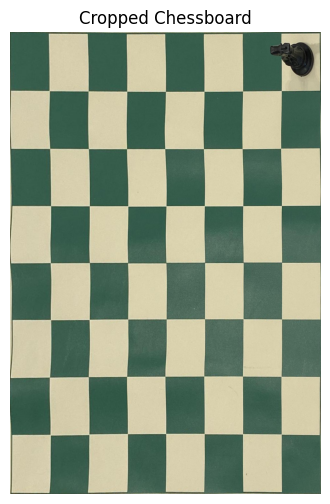

144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.0281120477659
144.028112

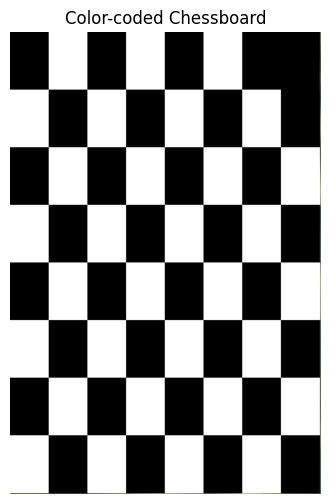

Black squares: 33
White squares: 31
Black Square Accuracy: 100.00%
White Square Accuracy: 96.88%
Overall Accuracy: 98.44%


In [15]:
# Process first image
black_acc1, white_acc1, overall_acc1 = process_chessboard(
    image1, approx1, expected_black, expected_white, debug=True
)



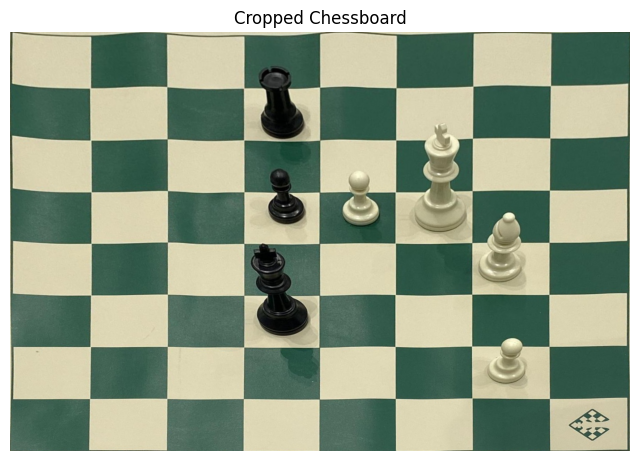

141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.5502327774637
141.550232

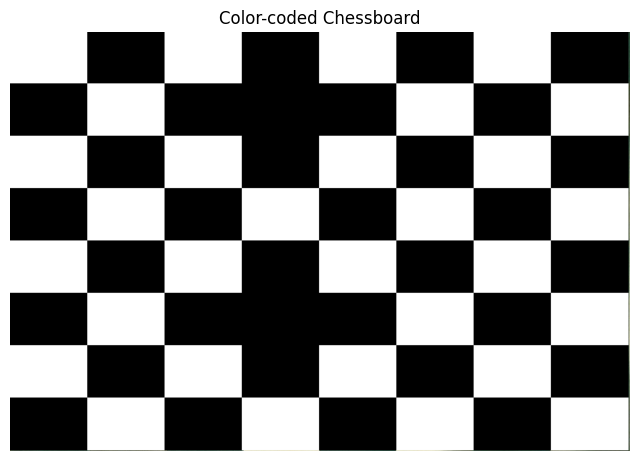

Black squares: 34
White squares: 30
Black Square Accuracy: 100.00%
White Square Accuracy: 93.75%
Overall Accuracy: 96.88%


In [16]:
# Process second image
black_acc2, white_acc2, overall_acc2 = process_chessboard(
    image2, approx2, expected_black, expected_white, debug=True
)